# COMP41680 Assignment 1
By: Vinay Bhardwaj <br>
Student Number: 19200487

In [0]:
import os
import urllib.request
import csv
import pandas as pd 
import json
from pandas.io.json import json_normalize
import numpy as np
import time
from google.colab import files
from pandas_profiling import ProfileReport

## Data identification and Collection: 


I am using <b>Financial Modeling Prep API</b> for data collection which is a free api for access to stock market data. Since this assignment is based on collection of data and managing that data, we will collect data about all the listed companies in markets rather than selecting one or two company and looking at thier historical data. This service covers NYSE, NASAQ, AMEX, EURONEX, TSX, INDEXES, ETFs, MUTUAL FUNDS, FOREX and CRYPTO data. Also, they provide real time stock price, along with the fundamental data part of the stocks via providing income statement, balance sheet statement and cashflow statement quaterly and annually.<br>
This api provides data in JSON format which can be directly read into a pandas dataframe.

We will be using 3 endpoints in this assignment:
1. Symbol List - this will give us the symbols for every company listed on the mentioned stock exchanges. Features are:<br>
Symbol | Name | Price
2. Company Profile - we will use the fetched symbol list to get Company profiles for each of these companies. This includes data for a company such as 52 week high, 52 week low, market capitalization, and key stats to understand a company finance. Features are:<br>
Price| Beta| Volume Average| Market Capitalisation| Last Dividend| 52 week range| stock price change| stock price change in percentage| Company Name| Exchange| Description| Industry| Sector| CEO|Website and image
3. Company Quote - We can use the symbols to find Company quotes for all the companies which contain more data about share high and lows for the year and the related data for the day. Features are :<br>
symbol | price | change | previousClose | dayLow | dayHigh | yearHigh | yearLow | marketCap | priceAvg50 | priceAvg200 | volume | avgVolume

** All the data collected is real time, it is subject to change **

In [0]:
#fetching symbols for all companies
link = "https://financialmodelingprep.com/api/v3/company/stock/list"
stock_list_df = pd.read_json(link)
stock_list_df.head()

,symbolsList
0,"{'symbol': 'SPY', 'name': 'SPDR S&P 500', 'pri..."
1,"{'symbol': 'CMCSA', 'name': 'Comcast Corporati..."
2,"{'symbol': 'KMI', 'name': 'Kinder Morgan Inc.'..."
3,"{'symbol': 'INTC', 'name': 'Intel Corporation'..."
4,"{'symbol': 'MU', 'name': 'Micron Technology In..."


In [0]:
# the data is not in jumbled json so normal json_normalize command can separate the columns for us
stock_list_df = json_normalize(stock_list_df['symbolsList'])
stock_list_df.head()

,symbol,name,price,exchange
0,SPY,SPDR S&P 500,254.00,NYSE Arca
1,CMCSA,Comcast Corporation Class A Common Stock,34.57,Nasdaq Global Select
2,KMI,Kinder Morgan Inc.,13.75,New York Stock Exchange
3,INTC,Intel Corporation,52.37,Nasdaq Global Select
4,MU,Micron Technology Inc.,43.48,Nasdaq Global Select


A lot of rows in our list of stocks have missing name field, we will remove this to reduce data to be fetched further using this dataframe.

In [0]:
stock_list_df = stock_list_df[~((stock_list_df['name'].isna()) | (stock_list_df['name'] == ''))]
stock_list_df.shape

(13111, 4)

Saving stock_list_df dataframe to stock_list.csv file for further analysis.

In [0]:
stock_list_df.to_csv('stock_list.csv',index=False)
# files.download("stock_list.csv") # only required for use in google colab

In [0]:
stock_list_df.describe()

,price
count,13111.000000
mean,54.006376
std,2345.859969
min,0.000000
25%,6.380000
50%,16.490000
75%,30.965000
max,268126.000000


In [0]:
len(stock_list_df)

13111

Next, we can fetch all the company profiles(13111) using the symbols dataframe.<br>
This request is limited to 3 symbols to prevent exceeding server response time, so we will divide our 13111 records into splits to send a request of max 3 symbols at once. 
Also, we will add a wait time of 0.5 second to keep the load on server in check.

In [0]:
comp_df = pd.DataFrame() #create empty dataframe
comp_profile_link = 'https://financialmodelingprep.com/api/v3/company/profile/'
for comp_split in np.array_split(stock_list_df['symbol'],4500): #loop through splits of 3(max)
  newlink = comp_profile_link + comp_split.str.cat(sep=',') # create new link for companies
  if comp_df.empty:
    comp_df = pd.read_json(newlink) # fetch profile data
  else:
    comp_df = comp_df.append(pd.read_json(newlink)) # fetch profile data and append
  time.sleep(0.5)

In [0]:
comp_df.shape

(13111, 1)

Data for all the companies is available in the company profile endpoint.

In [0]:
comp_df.head()

,companyProfiles
0,"{'symbol': 'SPY', 'profile': {'price': 254.0, ..."
1,"{'symbol': 'CMCSA', 'profile': {'price': 34.57..."
2,"{'symbol': 'KMI', 'profile': {'price': 13.75, ..."
0,"{'symbol': 'INTC', 'profile': {'price': 52.37,..."
1,"{'symbol': 'MU', 'profile': {'price': 43.48, '..."


In [0]:
company_profile = json_normalize(comp_df['companyProfiles'])
company_profile.head()

,symbol,profile.price,profile.beta,profile.volAvg,profile.mktCap,profile.lastDiv,profile.range,profile.changes,profile.changesPercentage,profile.companyName,profile.exchange,profile.industry,profile.website,profile.description,profile.ceo,profile.sector,profile.image
0,SPY,254.00,0.999041,147892704,2.33116631E11,5.0668054,218.26-339.08,-7.20,(-2.76%),SPDR S&P 500,NYSE Arca,,http://www.spdrs.com,The investment seeks to provide investment res...,,,https://financialmodelingprep.com/images-New-j...
1,CMCSA,34.57,1.061551,28335354,1.57398254E11,0.84,31.71-47.74,-2.17,(-5.91%),Comcast Corporation Class A Common Stock,Nasdaq Global Select,Entertainment,https://corporate.comcast.com,Comcast Corp is a media and technology company...,Brian L. Roberts,Consumer Cyclical,https://financialmodelingprep.com/images-New-j...
2,KMI,13.75,0.75548,18834814,3.1144577E10,0.8,9.42-22.58,-0.73,(-5.04%),Kinder Morgan Inc.,New York Stock Exchange,Oil & Gas - Midstream,http://www.kindermorgan.com,Kinder Morgan Inc is an energy infrastructure ...,Steven J. Kean,Energy,https://financialmodelingprep.com/images-New-j...
3,INTC,52.37,0.90978,30390003,2.23986483E11,1.26,42.86-69.29,-3.17,(-5.71%),Intel Corporation,Nasdaq Global Select,Semiconductors,http://www.intel.com,Intel Corp is the world's largest chipmaker. I...,Brian M. Krzanich,Technology,https://financialmodelingprep.com/images-New-j...
4,MU,43.48,1.951096,29145220,4.8300626E10,0,31.13-61.19,-1.31,(-2.92%),Micron Technology Inc.,Nasdaq Global Select,Semiconductors,http://www.micron.com,Micron Technology Inc along with its subsidiar...,,Technology,https://financialmodelingprep.com/images-New-j...


Saving company_profile dataframe to company_profile.csv file for further analysis.

In [0]:
company_profile.to_csv('company_profile.csv',index=False)
# files.download("company_profile.csv") # only required for use in google colab

Next, we can fetch the quote data from quote api endpoint. There is no limit on the number of parameters for this endpoint, so we divide our list of 13111 into 100 splits for load balancing.

In [0]:
quote_df = pd.DataFrame() #create empty dataframe
quote_link = 'https://financialmodelingprep.com/api/v3/quote/'
for quote_split in np.array_split(stock_list_df['symbol'],100): #loop through 100 splits
  newlink = quote_link + quote_split.str.cat(sep=',') # create new link for companies
  if quote_df.empty:
    quote_df = pd.read_json(newlink) # fetch profile data
  else:
    quote_df = quote_df.append(pd.read_json(newlink)) # fetch profile data and append
  time.sleep(0.5)

In [0]:
quote_df.shape

(12057, 22)

Data for only 12057 companies is available in the quote endpoint. This can result in missing data at the time of join.

In [0]:
quote_df.head()

,symbol,name,price,changesPercentage,change,dayLow,dayHigh,yearHigh,yearLow,marketCap,priceAvg50,priceAvg200,volume,avgVolume,exhange,open,previousClose,eps,pe,earningsAnnouncement,sharesOutstanding,timestamp
0,AAPL,Apple Inc.,247.74,-4.14,-10.70,247.0500,255.87,327.85,170.27,1.083981e+12,282.989720,269.801360,51054153.0,48846970.0,NASDAQ,252.75,258.44,12.595,19.669710,2020-01-28T21:30:00.000+0000,4.375480e+09,2020-03-28 20:53:56
1,GM,General Motors Company,21.38,-5.23,-1.18,20.7400,21.96,41.90,14.33,3.055202e+10,28.048000,34.143955,17773517.0,14820266.0,NYSE,21.37,22.56,4.570,4.678337,2020-05-06T16:30:00.000+0000,1.428780e+09,2020-03-28 20:53:56
2,TVIX,VelocityShares Daily 2x VIX Short-Term ETN,376.00,13.94,46.00,353.4101,384.40,1000.00,38.33,NaN,228.780850,119.914030,3432491.0,12579864.0,NASDAQ,379.60,330.00,NaN,NaN,None,NaN,2020-03-28 20:53:56
3,CTRP,Trip.com Group Limited,34.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NASDAQ,NaN,NaN,NaN,NaN,None,NaN,2020-03-28 20:53:56
4,XRX,Xerox Holdings Corporation,17.66,-9.06,-1.76,17.5100,19.30,39.47,15.01,3.757853e+09,29.137142,33.284530,3918064.0,2594006.0,NYSE,19.03,19.42,5.803,3.043253,2020-01-28T18:30:00.000+0000,2.125900e+08,2020-03-28 20:53:56


Saving quote_df into quote.csv file for further analysis.

In [0]:
quote_df.to_csv('quote.csv',index=False)
# files.download("quote.csv") #only required for use in google colab

## Data preparation and analysis


Now that we have fetched and stored all the required data from our api into 3 files - stock_list.csv, company_profile.csv and quote.csv. We can load these files directly into our notebook and perform data analysis.

In [0]:
# to be used only in google colab
#files.upload()

In [0]:
# Re-loading the data into 3 pandas dataframes
symbols_df = pd.read_csv('stock_list.csv')
company_profile_df = pd.read_csv('company_profile.csv')
quote_df = pd.read_csv('quote.csv')

In [0]:
symbols_df.head(3)

,symbol,name,price,exchange
0,SPY,SPDR S&P 500,254.00,NYSE Arca
1,CMCSA,Comcast Corporation Class A Common Stock,34.57,Nasdaq Global Select
2,KMI,Kinder Morgan Inc.,13.75,New York Stock Exchange


In [0]:
company_profile_df.head(3)

,symbol,profile.price,profile.beta,profile.volAvg,profile.mktCap,profile.lastDiv,profile.range,profile.changes,profile.changesPercentage,profile.companyName,profile.exchange,profile.industry,profile.website,profile.description,profile.ceo,profile.sector,profile.image
0,SPY,254.00,0.999041,147892704,2.331166e+11,5.066805,218.26-339.08,-7.20,(-2.76%),SPDR S&P 500,NYSE Arca,NaN,http://www.spdrs.com,The investment seeks to provide investment res...,NaN,NaN,https://financialmodelingprep.com/images-New-j...
1,CMCSA,34.57,1.061551,28335354,1.573983e+11,0.840000,31.71-47.74,-2.17,(-5.91%),Comcast Corporation Class A Common Stock,Nasdaq Global Select,Entertainment,https://corporate.comcast.com,Comcast Corp is a media and technology company...,Brian L. Roberts,Consumer Cyclical,https://financialmodelingprep.com/images-New-j...
2,KMI,13.75,0.755480,18834814,3.114458e+10,0.800000,9.42-22.58,-0.73,(-5.04%),Kinder Morgan Inc.,New York Stock Exchange,Oil & Gas - Midstream,http://www.kindermorgan.com,Kinder Morgan Inc is an energy infrastructure ...,Steven J. Kean,Energy,https://financialmodelingprep.com/images-New-j...


In [0]:
quote_df.head(3)

,symbol,name,price,changesPercentage,change,dayLow,dayHigh,yearHigh,yearLow,marketCap,priceAvg50,priceAvg200,volume,avgVolume,exhange,open,previousClose,eps,pe,earningsAnnouncement,sharesOutstanding,timestamp
0,AAPL,Apple Inc.,247.74,-4.14,-10.70,247.0500,255.87,327.85,170.27,1.083981e+12,282.98972,269.801360,51054153.0,48846970.0,NASDAQ,252.75,258.44,12.595,19.669710,2020-01-28T21:30:00.000+0000,4.375480e+09,2020-03-28 20:53:56
1,GM,General Motors Company,21.38,-5.23,-1.18,20.7400,21.96,41.90,14.33,3.055202e+10,28.04800,34.143955,17773517.0,14820266.0,NYSE,21.37,22.56,4.570,4.678337,2020-05-06T16:30:00.000+0000,1.428780e+09,2020-03-28 20:53:56
2,TVIX,VelocityShares Daily 2x VIX Short-Term ETN,376.00,13.94,46.00,353.4101,384.40,1000.00,38.33,NaN,228.78085,119.914030,3432491.0,12579864.0,NASDAQ,379.60,330.00,NaN,NaN,NaN,NaN,2020-03-28 20:53:56


Now we can join all our three dataframes to create a new combined dataframe to start analysis.

In [0]:
stock_market_df = symbols_df.set_index('symbol').join(company_profile_df.set_index('symbol'))
stock_market_df = stock_market_df.join(quote_df.set_index('symbol'),rsuffix='_base') # suffix for name and price repetition
stock_market_df.head()

,name,price,exchange,profile.price,profile.beta,profile.volAvg,profile.mktCap,profile.lastDiv,profile.range,profile.changes,profile.changesPercentage,profile.companyName,profile.exchange,profile.industry,profile.website,profile.description,profile.ceo,profile.sector,profile.image,name_base,price_base,changesPercentage,change,dayLow,dayHigh,yearHigh,yearLow,marketCap,priceAvg50,priceAvg200,volume,avgVolume,exhange,open,previousClose,eps,pe,earningsAnnouncement,sharesOutstanding,timestamp
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SPY,SPDR S&P 500,254.00,NYSE Arca,254.00,0.999041,147892704,2.331166e+11,5.066805,218.26-339.08,-7.20,(-2.76%),SPDR S&P 500,NYSE Arca,NaN,http://www.spdrs.com,The investment seeks to provide investment res...,NaN,NaN,https://financialmodelingprep.com/images-New-j...,SPDR S&P 500 ETF Trust,253.42,-2.98,-7.78,251.0794,260.81,339.08,218.26,2.325843e+11,291.602300,306.349370,224341217.0,147892704.0,NYSE,253.27,261.20,NaN,NaN,NaN,9.177820e+08,2020-03-28 20:53:56
CMCSA,Comcast Corporation Class A Common Stock,34.57,Nasdaq Global Select,34.57,1.061551,28335354,1.573983e+11,0.840000,31.71-47.74,-2.17,(-5.91%),Comcast Corporation Class A Common Stock,Nasdaq Global Select,Entertainment,https://corporate.comcast.com,Comcast Corp is a media and technology company...,Brian L. Roberts,Consumer Cyclical,https://financialmodelingprep.com/images-New-j...,Comcast Corporation,34.57,-5.91,-2.17,34.4100,35.79,47.74,31.71,1.573983e+11,40.500000,43.789280,27174264.0,28335354.0,NASDAQ,35.59,36.74,2.830,12.215548,2020-01-23T12:00:00.000+0000,4.543590e+09,2020-03-28 20:53:56
KMI,Kinder Morgan Inc.,13.75,New York Stock Exchange,13.75,0.755480,18834814,3.114458e+10,0.800000,9.42-22.58,-0.73,(-5.04%),Kinder Morgan Inc.,New York Stock Exchange,Oil & Gas - Midstream,http://www.kindermorgan.com,Kinder Morgan Inc is an energy infrastructure ...,Steven J. Kean,Energy,https://financialmodelingprep.com/images-New-j...,"Kinder Morgan, Inc.",13.75,-5.04,-0.73,13.5900,14.36,22.58,9.42,3.114458e+10,17.732286,19.834461,20263647.0,18834814.0,NYSE,13.76,14.48,0.962,14.293139,2020-01-22T21:05:00.000+0000,2.264970e+09,2020-03-28 20:53:56
INTC,Intel Corporation,52.37,Nasdaq Global Select,52.37,0.909780,30390003,2.239865e+11,1.260000,42.86-69.29,-3.17,(-5.71%),Intel Corporation,Nasdaq Global Select,Semiconductors,http://www.intel.com,Intel Corp is the world's largest chipmaker. I...,Brian M. Krzanich,Technology,https://financialmodelingprep.com/images-New-j...,Intel Corporation,52.37,-5.71,-3.17,52.0650,54.64,69.29,42.86,2.239865e+11,56.993140,56.927628,31633487.0,30390003.0,NASDAQ,53.42,55.54,4.710,11.118896,2020-04-24T00:00:00.000+0000,4.350000e+09,2020-03-28 20:53:56
MU,Micron Technology Inc.,43.48,Nasdaq Global Select,43.48,1.951096,29145220,4.830063e+10,0.000000,31.13-61.19,-1.31,(-2.92%),Micron Technology Inc.,Nasdaq Global Select,Semiconductors,http://www.micron.com,Micron Technology Inc along with its subsidiar...,NaN,Technology,https://financialmodelingprep.com/images-New-j...,"Micron Technology, Inc.",43.48,-2.92,-1.31,42.3100,45.28,61.19,31.13,4.830063e+10,49.210285,49.834170,39791531.0,29145220.0,NASDAQ,43.25,44.79,2.025,21.471603,2020-03-25T20:01:10.000+0000,1.110870e+09,2020-03-28 20:53:56


In [0]:
stock_market_df.shape

(13111, 40)

The stock_market_df contains duplicate columns and all the column names from company_profile_df have "profile." as prefix. So, we need to give standard stucture to the dataframe.

In [0]:
stock_market_df = stock_market_df.drop(['name_base','price_base','profile.price','profile.exchange','profile.mktCap',
                                        'profile.companyName','exhange','profile.volAvg','profile.changes','profile.changesPercentage'],axis=1)
stock_market_df.rename(columns={'profile.beta':'beta','profile.lastDiv':'lastDiv','profile.range':'range','profile.industry':'industry',
                                'profile.website':'website','profile.description':'description','profile.ceo':'ceo','profile.sector':'sector',
                                'profile.image':'image'},inplace=True)

In [0]:
stock_market_df.head(2)

,name,price,exchange,beta,lastDiv,range,industry,website,description,ceo,sector,image,changesPercentage,change,dayLow,dayHigh,yearHigh,yearLow,marketCap,priceAvg50,priceAvg200,volume,avgVolume,open,previousClose,eps,pe,earningsAnnouncement,sharesOutstanding,timestamp
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SPY,SPDR S&P 500,254.00,NYSE Arca,0.999041,5.066805,218.26-339.08,NaN,http://www.spdrs.com,The investment seeks to provide investment res...,NaN,NaN,https://financialmodelingprep.com/images-New-j...,-2.98,-7.78,251.0794,260.81,339.08,218.26,2.325843e+11,291.6023,306.34937,224341217.0,147892704.0,253.27,261.20,NaN,NaN,NaN,9.177820e+08,2020-03-28 20:53:56
CMCSA,Comcast Corporation Class A Common Stock,34.57,Nasdaq Global Select,1.061551,0.840000,31.71-47.74,Entertainment,https://corporate.comcast.com,Comcast Corp is a media and technology company...,Brian L. Roberts,Consumer Cyclical,https://financialmodelingprep.com/images-New-j...,-5.91,-2.17,34.4100,35.79,47.74,31.71,1.573983e+11,40.5000,43.78928,27174264.0,28335354.0,35.59,36.74,2.83,12.215548,2020-01-23T12:00:00.000+0000,4.543590e+09,2020-03-28 20:53:56


In [0]:
display(stock_market_df.select_dtypes(include=[np.number]).describe())
display(stock_market_df.select_dtypes(include=[np.object]).describe())

,price,beta,lastDiv,changesPercentage,change,dayLow,dayHigh,yearHigh,yearLow,marketCap,priceAvg50,priceAvg200,volume,avgVolume,open,previousClose,eps,pe,sharesOutstanding
count,13111.000000,9945.000000,7936.000000,12001.000000,11985.000000,10471.000000,10472.000000,11985.000000,11985.000000,7.967000e+03,11889.000000,11891.000000,1.047400e+04,1.188900e+04,10458.000000,11974.000000,7182.000000,4463.000000,7.951000e+03
mean,54.006376,1.213666,0.651851,-2.465757,-1.416184,59.817787,62.391717,94.321687,48.067450,6.279736e+09,68.279832,72.415215,1.469493e+06,1.027449e+06,60.593879,58.009428,15.471725,40.949423,2.035117e+08
std,2345.859969,23.621458,0.990196,10.710553,73.043748,2599.771554,2700.492334,3248.614596,2191.571859,3.469322e+10,2817.080012,2966.576815,7.483297e+06,4.516386e+06,2621.318138,2527.363251,831.794468,421.849072,1.030887e+09
min,0.000000,-127.710380,0.000000,-100.000000,-7969.000000,0.000000,0.000000,0.005900,0.000000,0.000000e+00,0.000806,0.001000,0.000000e+00,0.000000e+00,0.000000,0.000000,-173.088000,0.000000,0.000000e+00
25%,6.380000,0.416040,0.000000,-4.790000,-0.976900,4.950000,5.403000,12.880000,4.465000,8.141853e+07,8.859428,9.875878,1.200775e+04,4.924000e+03,5.200000,6.700000,-0.418250,7.017216,1.551820e+07
50%,16.490000,0.881968,0.288549,-2.730000,-0.300000,14.800000,15.700000,25.800000,13.050000,3.873142e+08,20.155800,21.838848,1.191560e+05,7.517700e+04,15.225000,16.940000,0.460000,11.763117,4.282140e+07
75%,30.965000,1.306153,0.977295,0.000000,0.000000,30.140000,31.664825,48.880000,25.080000,2.299357e+09,37.194000,40.435757,7.050355e+05,5.403900e+05,30.797500,31.909675,2.070000,22.972452,1.208675e+08
max,268126.000000,2284.777800,18.000000,918.900000,559.990000,265558.620000,275882.500000,347400.000000,239440.000000,1.174977e+12,305744.840000,322112.800000,3.639679e+08,1.726143e+08,267600.000000,276095.000000,49828.453000,21049.998000,6.119990e+10


,name,exchange,range,industry,website,description,ceo,sector,image,earningsAnnouncement,timestamp
count,13111,13111,13111,8325,10143,12866,4822,8325,13111,5330,12057
unique,12834,21,13050,234,7354,11686,4296,15,13111,2800,63
top,Brookfield Property Partners L.P.,New York Stock Exchange,0-0,Asset Management,http://www.ishares.com,The investment seeks to provide investors with...,John M. Perlowski,Financial Services,https://financialmodelingprep.com/images-New-j...,2020-03-13T00:00:00.000+0000,2020-03-28 20:54:37
freq,4,2602,3,777,337,12,70,1843,1,69,262


Checking amount of nulls in each column.

In [0]:
stock_market_df.isnull().sum()

name                       0
price                      0
exchange                   0
beta                    3166
lastDiv                 5175
range                      0
industry                4786
website                 2968
description              245
ceo                     8289
sector                  4786
image                      0
changesPercentage       1110
change                  1126
dayLow                  2640
dayHigh                 2639
yearHigh                1126
yearLow                 1126
marketCap               5144
priceAvg50              1222
priceAvg200             1220
volume                  2637
avgVolume               1222
open                    2653
previousClose           1137
eps                     5929
pe                      8648
earningsAnnouncement    7781
sharesOutstanding       5160
timestamp               1054
dtype: int64

From the above description of our data we can see a lot of columns have null values. For fixing this, there are many ways which include removing these rows, or filling them with a value like 0 or mean of the column. For this type of financial data filling a random value is not appropriate. We can select the columns we have to use for our analysis and then remove rows according to these columns.

One common number of nulls is 1126 for yearHigh,yearLow and change. This can be inspected.

In [0]:
stock_market_df[stock_market_df['yearHigh'].isna()].head()

,name,price,exchange,beta,lastDiv,range,industry,website,description,ceo,sector,image,changesPercentage,change,dayLow,dayHigh,yearHigh,yearLow,marketCap,priceAvg50,priceAvg200,volume,avgVolume,open,previousClose,eps,pe,earningsAnnouncement,sharesOutstanding,timestamp
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HK,Halcon Resources Corporation,0.19,New York Stock Exchange,3.749532,0.00,1.17-5.89,Oil & Gas - E&P,http://www.halconresources.com,Halcon Resources Corp is an independent oil an...,Floyd C. Wilson,Energy,https://financialmodelingprep.com/images-New-j...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WFT,Weatherford International plc (Ireland),0.36,New York Stock Exchange,2.194283,0.00,0.2164-3.75,Oil & Gas - Services,http://www.weatherford.com,Weatherford International PLC together with it...,Mark A. Mccollum,Energy,https://financialmodelingprep.com/images-New-j...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DWDP,DowDuPont Inc.,30.51,New York Stock Exchange,0.971702,1.52,36.09-71.93,Chemicals,http://www.dow-dupont.com,DowDuPont Inc is jointly owned by Dow and DuPo...,Edward D. Breen,Basic Materials,https://financialmodelingprep.com/images-New-j...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WP,Worldpay Inc. Class A,124.37,New York Stock Exchange,0.896607,0.00,70.41-115.68,Business Services,http://www.worldpay.com,Worldpay Inc is a payment processing company t...,Philip Jansen / Charles D. Drucker,Industrials,https://financialmodelingprep.com/images-New-j...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLNS,Colony NorthStar Inc.,6.41,New York Stock Exchange,1.356758,0.44,5.28-14.74,REITs,http://www.clns.com,Colony NorthStar Inc is a real estate and inve...,Richard B. Saltzman,Real Estate,https://financialmodelingprep.com/images-New-j...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As seen above all the numerical values except price are missing for these value for the small sample. We can remove these nulls as we can use yearHigh,yearLow and change for our analysis.

In [0]:
stock_market_df = stock_market_df[stock_market_df['yearHigh'].notna()]

In [0]:
stock_market_df.shape

(11985, 30)

In [0]:
stock_market_df.isnull().sum()

name                       0
price                      0
exchange                   0
beta                    3166
lastDiv                 5174
range                      0
industry                4427
website                 2837
description              183
ceo                     7841
sector                  4427
image                      0
changesPercentage          0
change                     0
dayLow                  1514
dayHigh                 1513
yearHigh                   0
yearLow                    0
marketCap               4018
priceAvg50                96
priceAvg200               94
volume                  1511
avgVolume                 96
open                    1527
previousClose             11
eps                     4803
pe                      7522
earningsAnnouncement    6655
sharesOutstanding       4034
timestamp                  0
dtype: int64

As we can see after removing the 1126 entries our dataset is a lot less sparce and we have not lost a lot of data either. This is now an acceptable dataset and we can begin our analysis and alter according to our needs.

In [0]:
stock_market_df['exchange'].unique()

array(['NYSE Arca', 'Nasdaq Global Select', 'New York Stock Exchange',
       'NASDAQ Global Market', 'NASDAQ Capital Market', 'BATS Exchange',
       'NYSE American', 'Nasdaq', 'NYSE', 'NasdaqGM', 'NasdaqCM',
       'NasdaqGS', 'Other OTC', 'YHD', 'Paris', 'Amsterdam', 'Brussels',
       'Lisbon', 'Toronto', 'NYSEArca', 'BATS'], dtype=object)

#### 1. Which companies have the highest prices(Top 10) for their stock in NYSE or New York Stock Exchange?

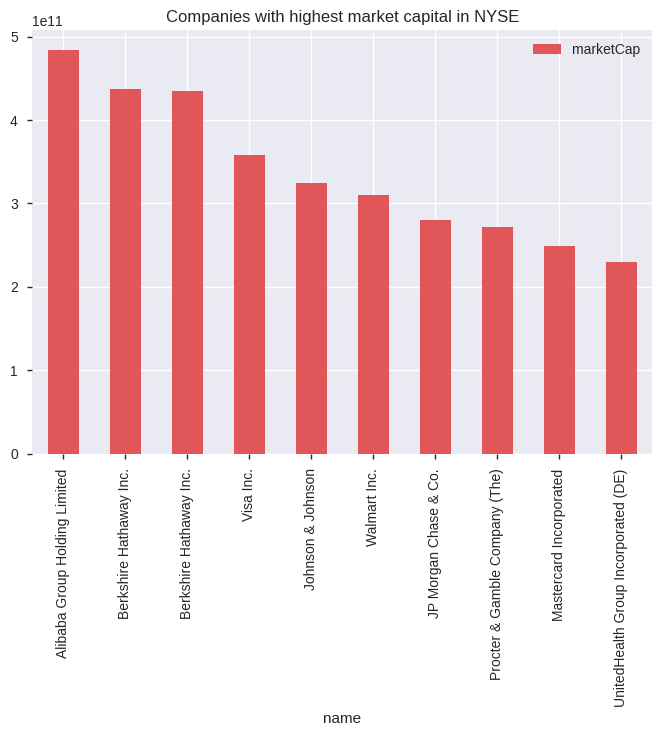

In [0]:
top10mktCap_NYSE = stock_market_df[(stock_market_df['exchange'] == 'NYSE')  |
                (stock_market_df['exchange'] == 'New York Stock Exchange')].sort_values(by=['marketCap'],ascending=False)[['name','marketCap']].head(10)
top10mktCap_NYSE.set_index('name').plot.bar(title='Companies with highest market capital in NYSE',color='#e15759')

#### 2. Which companies have the highest marketCap(Top 10) for their stock in Nasdaq Global Select?

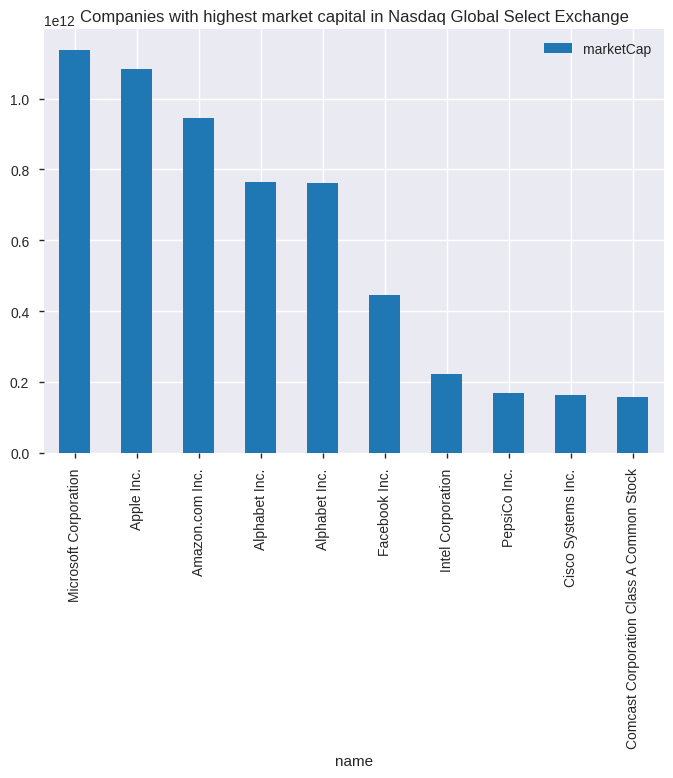

In [0]:
top10mktCap_Nasdaq = stock_market_df[(stock_market_df['exchange'] == 'Nasdaq Global Select')].sort_values(by=['marketCap'],ascending=False)[['name','marketCap']].head(10)
top10mktCap_Nasdaq.set_index('name').plot.bar(title='Companies with highest market capital in Nasdaq Global Select Exchange')

Well, we have found some of the giants in the world. Now we can check some emerging companies with the highest Change in their stock value for the day data was collected.

#### 3. Which companies have the highest Change Percentage(Top 10) for their stock in Nasdaq Global Select or NYSE?

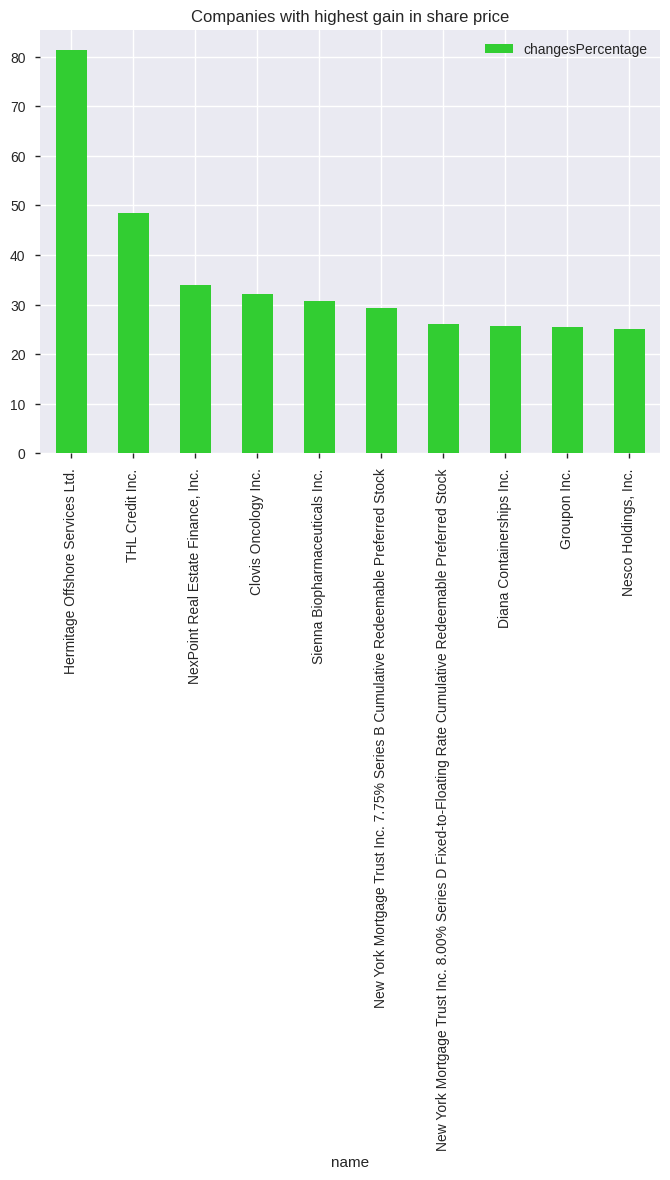

In [0]:
top10_changePerct = stock_market_df[(stock_market_df['exchange'] == 'Nasdaq Global Select') | 
                                    (stock_market_df['exchange'] == 'NYSE') | 
                                    (stock_market_df['exchange'] == 'New York Stock Exchange')].sort_values(by=['changesPercentage'],ascending=False)[['name','changesPercentage']].head(10)
top10_changePerct.set_index('name').plot.bar(title='Companies with highest gain in share price',color='limegreen')

#### 4. Which companies have performed badly on the data collection day in  Nasdaq Global Select or NYSE?

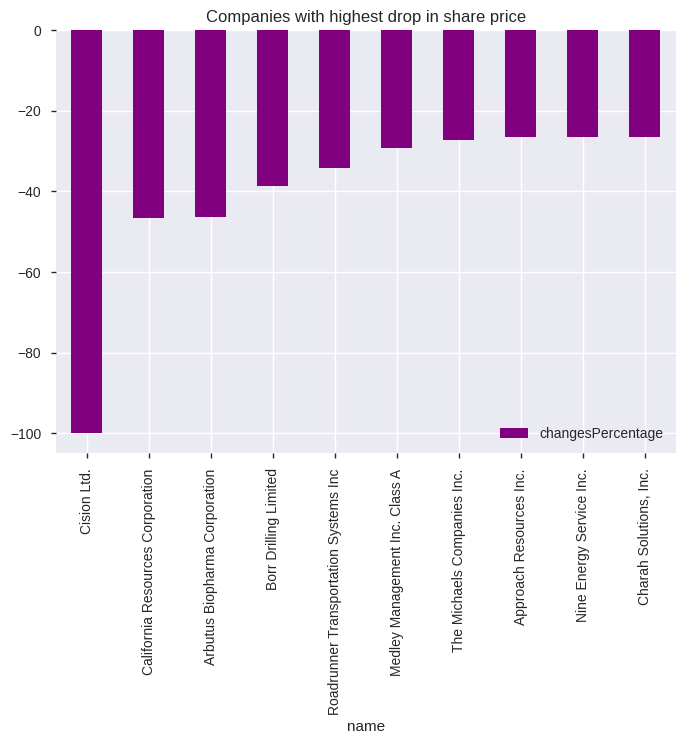

In [0]:
least10_changePerct = stock_market_df[(stock_market_df['exchange'] == 'Nasdaq Global Select') | 
                                    (stock_market_df['exchange'] == 'NYSE') | 
                                    (stock_market_df['exchange'] == 'New York Stock Exchange')].sort_values(by=['changesPercentage'])[['name','changesPercentage']].head(10)
least10_changePerct.set_index('name').plot.bar(title='Companies with highest drop in share price',color='purple')

#### 5. Which stock exchange has the highest market capital sum listed?

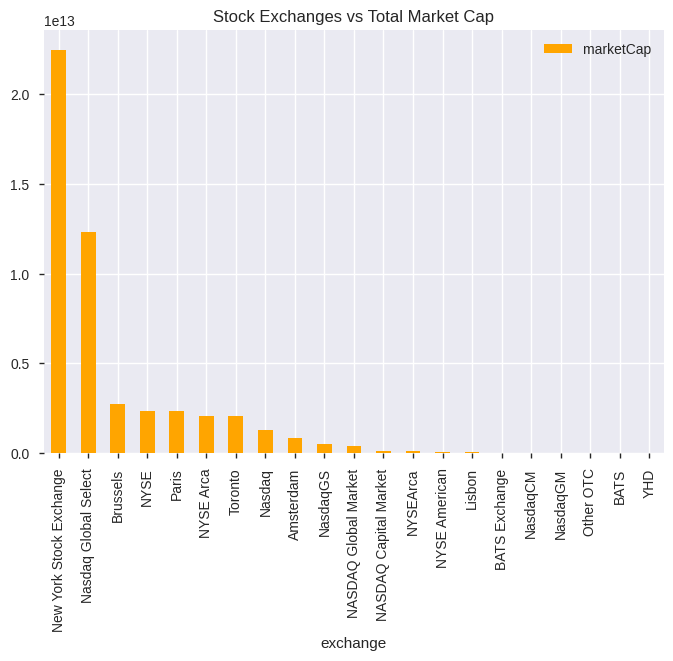

In [0]:
total_exchange_cap = stock_market_df.groupby('exchange',as_index=False)['marketCap'].sum()
total_exchange_cap.sort_values(by=['marketCap'],ascending=False).set_index('exchange').plot.bar(title='Stock Exchanges vs Total Market Cap',color='orange')

In [0]:
profile = ProfileReport(stock_market_df)
profile